<a href="https://colab.research.google.com/github/kunalavghade/Ai/blob/main/Week_9_%E2%80%94_Pooling%2C_CNN_Layers_%26_Forward_Pass_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 9 — Pooling, CNN Layers & Forward Pass Architecture

## Goal

Move from isolated convolution to building a structured CNN.

By the end of this week, you should:
- Implement max pooling from scratch
- Understand downsampling and invariance
- Build a modular Conv → ReLU → Pool block
- Construct a full CNN forward pass
- Understand feature hierarchy

No full training yet. Focus on forward mechanics + architecture design.

---

# 1. Why Pooling?

Convolution extracts features.
Pooling compresses them.

Pooling:
- Reduces spatial dimensions
- Reduces computation
- Introduces local translation invariance

---

# 2. Max Pooling

Operation:
- Take k × k window
- Output maximum value

Example:
2×2 window → 1 output

Purpose:
- Keep strongest activation
- Discard small variations

---

# 3. Pooling Parameters

- Kernel size (e.g., 2×2)
- Stride (often equal to kernel size)
- No learnable parameters

Output size:

(H − k)/stride + 1

---

# 4. Translation Invariance vs Equivariance

Convolution:
- Translation equivariant
  (shift input → shift output)

Pooling:
- Adds approximate invariance
  (small shifts don’t change output much)

---

# 5. CNN Block Design

Standard block:

Conv → Activation → Pool

Example:

Input (28×28)
→ Conv (3×3, 8 filters)
→ ReLU
→ MaxPool (2×2)
→ Conv (3×3, 16 filters)
→ ReLU
→ MaxPool
→ Flatten
→ Fully Connected
→ Output

---

# 6. Flattening

Before feeding into fully connected layer:

(H × W × C) → vector

This connects spatial features to classifier.

---

# 7. Feature Hierarchy

Layer 1:
- Edges

Layer 2:
- Corners / textures

Layer 3:
- Shapes

Deeper layers:
- Object parts

CNN builds hierarchical representations.

---

# Coding Exercises

## Question 1: Implement Max Pooling

Implement:
- 2D max pooling
- Arbitrary kernel size
- Arbitrary stride

Test:
- Small random matrix
- Verify dimensions manually

---

## Question 2: Combine Conv + ReLU + Pool

Create a class:

ConvBlock:
- conv_forward
- relu_forward
- pool_forward

Test:
- Random input
- Verify output shape

---

## Question 3: Build Full CNN Forward Pass

Construct architecture:

Input (28×28)
→ Conv(3×3, 8)
→ ReLU
→ Pool(2×2)
→ Conv(3×3, 16)
→ ReLU
→ Pool(2×2)
→ Flatten
→ FC
→ Softmax

Only implement forward pass.

Verify:
- Output dimensions
- Probability distribution

---

## Question 4: Visualize Feature Maps

After first convolution:
- Plot all feature maps
- Observe edge detectors

After second convolution:
- Observe abstract patterns

---

## Question 5: Parameter Counting

Compute:
- Total parameters in CNN
- Total parameters in equivalent MLP

Compare counts.

---

# Conceptual Questions

1. Why does pooling improve robustness?
2. Why do deeper CNN layers learn more abstract features?
3. Why does CNN need fewer parameters than MLP?
4. Why is flattening required before FC?
5. What structural assumption does CNN encode?

---

# Outcome of Week 9

After this week, you should:
- Understand CNN architecture design
- Build forward pass cleanly
- Visualize feature maps
- Think in terms of spatial hierarchy


**Load Real Image Data (MNIST)**

Label: 5
Shape: (28, 28)


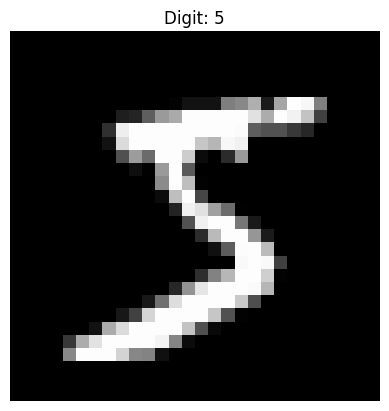

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

np.random.seed(42)

#load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#normalize
X_train = X_train / 255.0
X_test = X_test / 255.0

# Take one real image
image = X_train[0]
label = y_train[0]

print("Label:", label)
print("Shape:", image.shape)

# Plot the image
plt.imshow(image, cmap='gray')
plt.imshow(image, cmap='gray')
plt.title(f"Digit: {label}")
plt.axis('off')
plt.show()



**Question 1 — Max Pooling (Real Image Test)**

In [6]:
def max_pool2d(X, kernel_size = 2, stride = 2):
  H, W = X.shape

  out_h = (H - kernel_size) // stride + 1
  out_w = (W - kernel_size) // stride + 1

  output = np.zeros((out_h, out_w))

  for i in range(out_h):
    for j in range(out_w):
      h_start = i * stride
      h_end = h_start + kernel_size
      w_start = j * stride
      w_end = w_start + kernel_size

      window = X[h_start:h_end, w_start: w_end]
      output[i, j] = np.max(window)

  return output

Test on Real MNIST Image

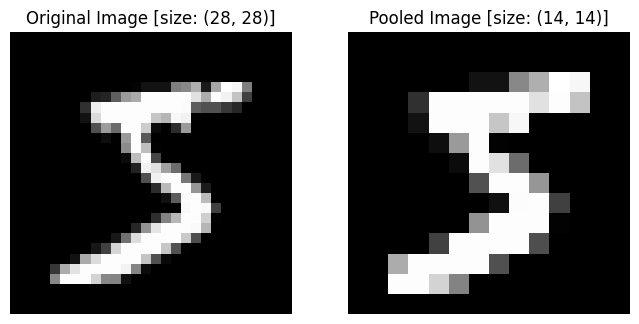

In [7]:
pooled = max_pool2d(image, kernel_size = 2, stride = 2)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title(f"Original Image [size: {image.shape}]")
plt.imshow(image, cmap='gray')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Pooled Image [size: {pooled.shape}]")
plt.imshow(pooled, cmap='gray')
plt.axis("off")

plt.show()

**Question 2 — Conv → ReLU → Pool Block (Real Data)**

Convolution (Multi Filter)

In [8]:
def conv2d(X, filter, stride =1):
  H, W = X.shape
  num_filters, k ,  _ = filter.shape

  out_h = (H - k) // stride + 1
  out_w = (W - k) // stride + 1

  output = np.zeros((num_filters, out_h, out_w))

  for f in range(num_filters):
    for i in range(out_h):
      for j in range(out_w):
        h_start = i * stride
        h_end = h_start + k

        w_start = j * stride
        w_end = w_start + k

        window = X[h_start:h_end, w_start:w_end]
        output[f, i, j] = np.sum(window * filter[f])

  return output

ReLU

In [9]:
def relu(X):
  return np.maximum(X, 0)

ConvBlock

In [11]:
class ConvBlock:
  def __init__(self, num_filters, kernel_size):
    self.filters = np.random.randn(num_filters, kernel_size, kernel_size) * 0.1
    self.kernel_size  = kernel_size

  def forward(self, X):
    conv_out = conv2d(X, self.filters)
    relu_out = relu(conv_out)

    pooled = []
    for channel in relu_out:
      pooled.append(max_pool2d(channel, kernel_size=2, stride =2))

    return np.array(pooled)

Test Block on Real Image

In [13]:
block = ConvBlock(num_filters=8, kernel_size=3)
output = block.forward(image)

print("Output shape:", output.shape)

Output shape: (8, 13, 13)


**Question 4 — Visualize Real Feature Maps**

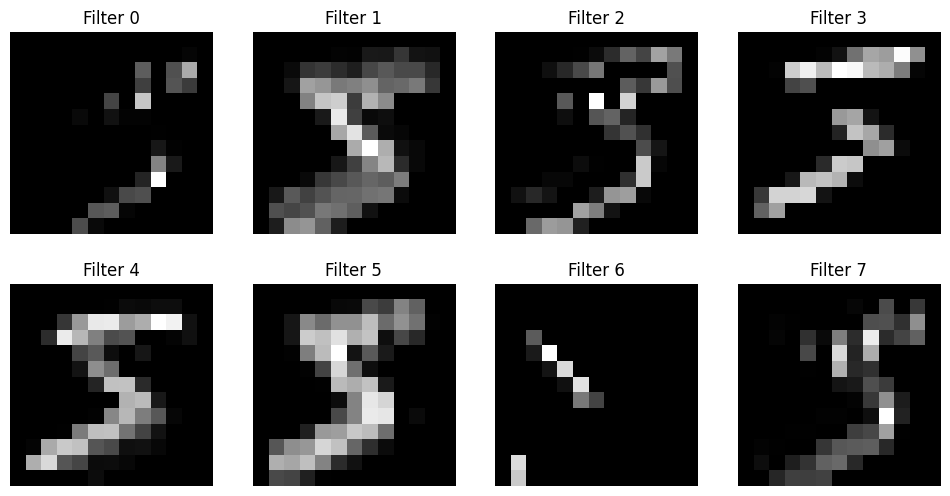

In [14]:
plt.figure(figsize=(12, 6))
for i in range(8):
  plt.subplot(2, 4, i + 1)
  plt.imshow(output[i], cmap='gray')
  plt.title(f"Filter {i}")
  plt.axis("off")

plt.show()

**Question 3 — Full CNN Forward Pass (Real Image):**

Architecture:

28×28
→ Conv(3×3, 8)
→ Pool
→ Conv(3×3, 16)
→ Pool
→ Flatten
→ FC
→ Softmax

Fully Connected + Softmax

In [25]:
def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x)

class FullyConnected:
    def __init__(self, input_size, output_size):
        self.W = np.random.randn(output_size, input_size) * 0.1
        self.b = np.zeros(output_size)

    def forward(self, X):
        return self.W @ X + self.b

CNN Model

In [26]:
class SimpleCNN:
  def __init__(self):
    self.block1 = ConvBlock(num_filters=8, kernel_size=3)
    self.block2 = ConvBlock(num_filters=16, kernel_size=3)

    # After block1:
    # (8, 13, 13)
    # After block2:
    # 13 → 11 → pool → 5
    # Final shape = (16, 5, 5)

    self.fc = FullyConnected(input_size=16 * 5 * 5, output_size=10)

  def forward(self, X):
    out1 = self.block1.forward(X)

    # merge chanel for next block
    combined = np.sum(out1, axis=0)

    out2 = self.block2.forward(combined)

    # Flatten
    flattened = out2.flatten()

    logits = self.fc.forward(flattened)
    probs = softmax(logits)

    return probs



Run Forward on Real Digit

In [27]:
model = SimpleCNN()

probs = model.forward(image)

print("Output shape:", probs.shape)
print("Sum:", np.sum(probs))
print("Probabilities:", probs)


Output shape: (10,)
Sum: 0.9999999999999999
Probabilities: [0.11811653 0.10542535 0.10934343 0.10808746 0.12231035 0.0975266
 0.06223549 0.09373706 0.09532921 0.08788852]


**Question 5 — Parameter Counting**

**CNN**

Block1:
8 × 3×3 = 72

Block2:
16 × 3×3 = 144

FC:
(16×5×5) × 10 = 4000

10 bias

Total ≈ 4226 parameters

Equivalent MLP

784 → 400 → 10

784×400 = 313,600
400×10 = 4,000

Total ≈ 317,600

🔥 CNN uses 75× fewer parameters